Step   1 | Train MSE: 0.5703 | Test MSE: 0.5741 | Train Acc: 51.43% | Test Acc: 42.22%
Step   2 | Train MSE: 0.5086 | Test MSE: 0.5016 | Train Acc: 60.95% | Test Acc: 60.00%
Step   3 | Train MSE: 0.4887 | Test MSE: 0.4770 | Train Acc: 59.05% | Test Acc: 60.00%
Step   4 | Train MSE: 0.4716 | Test MSE: 0.4516 | Train Acc: 64.76% | Test Acc: 66.67%
Step   5 | Train MSE: 0.4487 | Test MSE: 0.4171 | Train Acc: 76.19% | Test Acc: 68.89%
Step   6 | Train MSE: 0.4273 | Test MSE: 0.3857 | Train Acc: 78.10% | Test Acc: 84.44%
Step   7 | Train MSE: 0.4126 | Test MSE: 0.3669 | Train Acc: 80.95% | Test Acc: 84.44%
Step   8 | Train MSE: 0.4040 | Test MSE: 0.3608 | Train Acc: 80.00% | Test Acc: 86.67%
Step   9 | Train MSE: 0.4001 | Test MSE: 0.3628 | Train Acc: 80.00% | Test Acc: 82.22%
Step  10 | Train MSE: 0.3987 | Test MSE: 0.3670 | Train Acc: 79.05% | Test Acc: 82.22%
Step  11 | Train MSE: 0.3983 | Test MSE: 0.3700 | Train Acc: 77.14% | Test Acc: 84.44%
Step  12 | Train MSE: 0.3979 | Test MSE: 0.

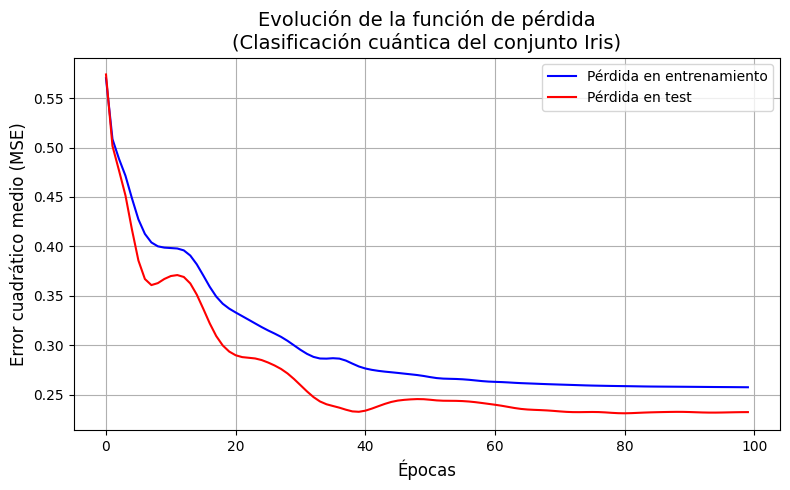

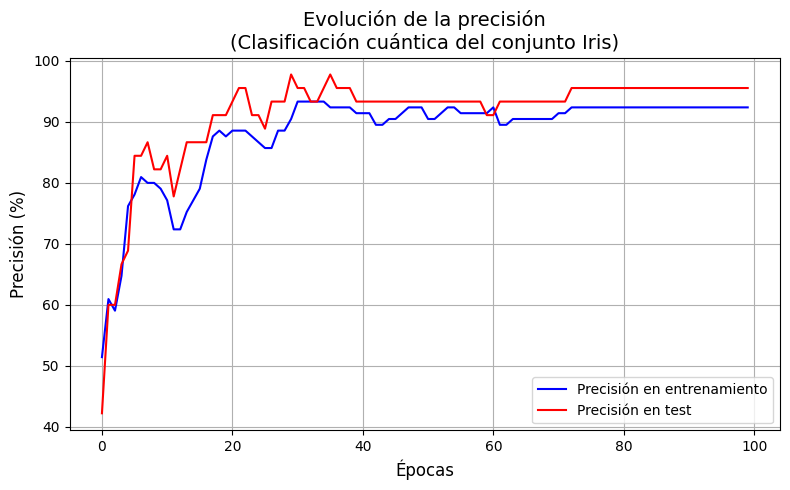

In [13]:
################################################################################
#9 layers
# 0.3
# 100 epochs
# 30 min
# 0.9524
# 0.9556
################################################################################


import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random

# ─── Semilla para reproducibilidad ─────────────────────────
seed = 42
random.seed(seed)
np.random.seed(seed)

# ─── 1) Cargar y preparar Iris ────────────────────────────
iris    = load_iris()
X       = MinMaxScaler().fit_transform(iris.data)  # (150,4)
y       = iris.target                             # (150,)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)
X_train = np.array(X_train, requires_grad=False)
X_test  = np.array(X_test,  requires_grad=False)

# One-hot de 3 clases en R⁴ (solo los primeros 3 índices)
label_map = {
    0: np.array([1.0, 0.0]),
    1: np.array([0.0, 1.0]),
    2: np.array([-1.0,-1.0]),
}
Y_train = np.array([label_map[c] for c in y_train], requires_grad=False)
Y_test  = np.array([label_map[c] for c in y_test],  requires_grad=False)

# ─── 2) Dispositivo cuántico de 4 qubits ─────────────────
n_qubits = 4
#dev = qml.device("default.qubit", wires=n_qubits, seed=seed)
dev = qml.device("lightning.qubit", wires=n_qubits)

# ─── 3) Feature map ───────────────────────────────────────
def feature_map(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(2 * x[i], wires=i)
    # entrelazamiento en anillo
    for i in range(n_qubits):
        j = (i + 1) % n_qubits
        qml.CNOT(wires=[i, j])
        qml.RZ(2 * (np.pi - x[i]) * (np.pi - x[j]), wires=j)
        qml.CNOT(wires=[i, j])

# ─── 4) Ansatz variacional ────────────────────────────────
def ansatz(params, layers):
    idx = 0
    for _ in range(layers):
        # rotaciones RY en cada qubit
        for i in range(n_qubits):
            qml.RY(params[idx], wires=i)
            idx += 1
        # entrelazamiento en anillo
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i+1) % n_qubits])
    # capa final de RY
    for i in range(n_qubits):
        qml.RY(params[idx], wires=i)
        idx += 1

# ─── 5) QNode: devuelve 4 expectativas ⟨Z_i⟩ ─────────────────
@qml.qnode(dev, interface="autograd")
def circuit(x, params, layers):
    feature_map(x)
    ansatz(params, layers)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits-2)]

# ─── 6) Función de coste MSE quantum-only ───────────────────
def cost(params, X, Y, layers):
    preds = [circuit(x, params, layers) for x in X]
    return np.mean((np.array(preds) - Y) ** 2)

# ─── 7) Clasificador por distancia a centroides ────────────
def classifier(x, params, layers):
    out = np.array(circuit(x, params, layers))
    dists = [np.linalg.norm(out - label_map[c]) for c in label_map]
    return int(np.argmin(dists))

def accuracy(X, y, params, layers):
    return sum(classifier(x, params, layers) == int(y_i) for x, y_i in zip(X, y)) / len(X)


# ─── 8) Entrenamiento con tracking de precisión ────────────
layers     = 10
n_q_params = n_qubits * layers + n_qubits
params     = np.random.uniform(0, np.pi, size=(n_q_params,), requires_grad=True)

opt    = qml.AdamOptimizer(stepsize=0.1)
steps  = 100
train_losses = []
test_losses  = []
train_accs   = []
test_accs    = []

start = time.time()
for i in range(steps):
    params = opt.step(lambda p: cost(p, X_train, Y_train, layers), params)
    
    # Pérdidas
    train_loss = cost(params, X_train, Y_train, layers)
    test_loss  = cost(params, X_test,  Y_test,  layers)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Precisión
    train_acc = accuracy(X_train, y_train, params, layers)
    test_acc  = accuracy(X_test,  y_test,  params, layers)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    #if (i + 1) % 10 == 0:
    print(f"Step {i+1:3d} | Train MSE: {train_loss:.4f} | Test MSE: {test_loss:.4f} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

elapsed = time.time() - start
print(f"\nTraining time: {elapsed:.1f} s")
print(f"Final train accuracy: {train_acc:.2%}")
print(f"Final test accuracy:  {test_acc:.2%}")


# ─── 10) Gráfica de pérdida ────────────────────────────────
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Pérdida en entrenamiento", color="blue")
plt.plot(test_losses, label="Pérdida en test", color="red")
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Error cuadrático medio (MSE)", fontsize=12)
plt.title("Evolución de la función de pérdida\n(Clasificación cuántica del conjunto Iris)", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ─── 11) Gráfica de precisión ──────────────────────────────
plt.figure(figsize=(8,5))
plt.plot([a*100 for a in train_accs], label="Precisión en entrenamiento", color="blue")
plt.plot([a*100 for a in test_accs],  label="Precisión en test", color="red")
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Precisión (%)", fontsize=12)
plt.title("Evolución de la precisión\n(Clasificación cuántica del conjunto Iris)", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
